# 第5章: 係り受け解析
夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

## 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [1]:
!head -n 24 ../data/neko.txt.cabocha

* 0 -1D 0/0 0.000000
一	名詞,数,*,*,*,*,一,イチ,イチ
EOS
EOS
* 0 2D 0/0 -0.764522
　	記号,空白,*,*,*,*,　,　,　
* 1 2D 0/1 -0.764522
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 2 -1D 0/2 0.000000
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
EOS
* 0 2D 0/1 -1.911675
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
* 1 2D 0/0 -1.911675
まだ	副詞,助詞類接続,*,*,*,*,まだ,マダ,マダ
* 2 -1D 0/0 0.000000
無い	形容詞,自立,*,*,形容詞・アウオ段,基本形,無い,ナイ,ナイ
。	記号,句点,*,*,*,*,。,。,。
EOS


In [2]:
from itertools import groupby

class Morph:

    def __init__(self, line):
        """
        Arguments
        line: str
            MeCabで形態素解析した一単語の結果。
            フォーマットは 表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原型,読み,発音
        """
        surface, pos, pos1, _, _, _, _, base, *other = [line.split('\t')[0]] + line.split('\t')[1].rstrip('\n').split(',')
        self.__surface = surface
        self.__base = base
        self.__pos = pos
        self.__pos1 = pos1
    
    @property
    def surface(self):
        return self.__surface
    
    @property
    def base(self):
        return self.__base
    
    @property
    def pos(self):
        return self.__pos

    @property
    def pos1(self):
        return self.__pos1
    
    def __str__(self):
        return str({'表層形':self.__surface, '原型':self.__base, '品詞':self.__pos, '品詞細分類1':self.__pos1})
    
def gen_morph_of_sentence(): 
    with open('../data/neko.txt.cabocha') as f:
        morph_of_sentense = []
        for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
            if is_eos:
                # 空行を1文とみなすための処理
                # 空行がある場合は連続したEOSがgroupbyでまとめられるため、EOSの数だけリストを返す
                for _ in sentence:
                    yield morph_of_sentense
                    morph_of_sentense = []
            else:
                for is_start_of_chunk, morphs_info in groupby(sentence, key=lambda line: 0 < len(line) and line[0] == '*'):
                    if not is_start_of_chunk:
                        morph_of_sentense += [ Morph(morph_info) for morph_info in morphs_info ]

for i, morph_of_sentence in enumerate(gen_morph_of_sentence()):
    if i== 2:
        for morph in morph_of_sentence:
            print(morph)    

{'表層形': '\u3000', '原型': '\u3000', '品詞': '記号', '品詞細分類1': '空白'}
{'表層形': '吾輩', '原型': '吾輩', '品詞': '名詞', '品詞細分類1': '代名詞'}
{'表層形': 'は', '原型': 'は', '品詞': '助詞', '品詞細分類1': '係助詞'}
{'表層形': '猫', '原型': '猫', '品詞': '名詞', '品詞細分類1': '一般'}
{'表層形': 'で', '原型': 'だ', '品詞': '助動詞', '品詞細分類1': '*'}
{'表層形': 'ある', '原型': 'ある', '品詞': '助動詞', '品詞細分類1': '*'}
{'表層形': '。', '原型': '。', '品詞': '記号', '品詞細分類1': '句点'}


## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [3]:
from itertools import groupby

class Chunk:
    
    def __init__(self, dependency_info, morphs_info):
        _, chunk_id, dst, *other = dependency_info.split(' ')
        self.__chunk_id = int(chunk_id)
        self.__dst = int(dst.rstrip('D'))
        self.__morphs = [ Morph(morph_info) for morph_info in morphs_info ]
        self.__srcs = []
    
    @property
    def chunk_id(self):
        return self.__chunk_id
    
    @property
    def dst(self):
        if self.__dst == -1:
            return None
        return self.__dst

    @property
    def srcs(self):
        return self.__srcs
    
    def add_src(self, src_index):
        self.__srcs.append(src_index)

    def get_surface(self):
        return ''.join(morph.surface for morph in self.__morphs)
    
    # for knock_42
    def get_surface_except_punctuation(self):
        return ''.join(morph.surface for morph in self.__morphs if morph.pos != '記号')    
    
    # for knock_43
    def has_noun(self):
        for morph in self.__morphs:
            if morph.pos == '名詞':
                return True
        return False
    
    # for knock_43
    def has_verb(self):
        for morph in self.__morphs:
            if morph.pos == '動詞':
                return True
        return False
    
    # for knock_45
    def get_first_verb(self):
        # 最左の動詞の基本形を取得する
        for morph in self.__morphs:
            if morph.pos == '動詞':
                return morph.base
        return None
    
    # for knock_45
    def get_last_particle(self):
        # 最右の助詞の表層形を取得する
        for morph in reversed(self.__morphs):
            if morph.pos == '助詞':
                return morph.surface
        return None
    
    # for knock_47
    def get_sahen_noun_and_wo(self):
        for i, morph in reversed(list(enumerate(self.__morphs))):
            if morph.pos == '助詞' and morph.surface == 'を':
                if i != 0 and self.__morphs[i-1].pos == '名詞' and self.__morphs[i-1].pos1 == 'サ変接続':
                    return self.__morphs[i-1].surface + morph.surface
        return None
        
    def __str__(self):
        msg = str(self.chunk_id) + ' '
        msg += self.get_surface()
        msg += '\tdst：' + str(self.dst)
        return msg
    

def gen_chunks_in_sentence():
    with open('../data/neko.txt.cabocha') as f:
        chunks_in_a_sentence = []
        for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
            if is_eos:
                # 空行を1文とみなすための処理
                # 空行がある場合は連続したEOSがgroupbyでまとめられるため、EOSの数だけリストを返す
                for _ in sentence:
                    for chunk in chunks_in_a_sentence:
                        # 各chunkの係り先のchunkに対して、自身のidをsrcとして設定
                        dst = chunk.dst
                        if dst is not None:
                            chunks_in_a_sentence[dst].add_src(chunk.chunk_id)
                    yield chunks_in_a_sentence
                    chunks_in_a_sentence = []
            else:
                dependency_info = None
                for is_start_of_chunk, chunk_info in groupby(sentence, key=lambda line: 0 < len(line) and line[0] == '*'):
                    if is_start_of_chunk:
                        dependency_info = list(chunk_info)[0]
                    else:
                        morphs_info = list(chunk_info)
                        chunk = Chunk(dependency_info, morphs_info)
                        chunks_in_a_sentence.append(chunk)
            
for i, chunks_in_sentence in enumerate(gen_chunks_in_sentence()):
    if i == 7:
        for chunk in chunks_in_sentence:
            print(chunk)

0 吾輩は	dst：5
1 ここで	dst：2
2 始めて	dst：3
3 人間という	dst：4
4 ものを	dst：5
5 見た。	dst：None


## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [4]:
from itertools import islice

def knock_42():
    for chunks_in_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_sentence:
            dst = chunk.dst
            if dst is None:
                continue
            src_surface = chunk.get_surface_except_punctuation()
            dst_surface = chunks_in_sentence[dst].get_surface_except_punctuation()
            if src_surface != '' and dst_surface != '':
                yield src_surface + '\t' + dst_surface
                
for chunk in islice(knock_42(), 30):
    print(chunk)               

吾輩は	猫である
名前は	無い
まだ	無い
どこで	生れたか
生れたか	つかぬ
とんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	所で
じめじめした	所で
所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	種族であったそうだ
あとで	聞くと
聞くと	種族であったそうだ
それは	種族であったそうだ
書生という	人間中で
人間中で	種族であったそうだ
一番	獰悪な
獰悪な	種族であったそうだ
この	書生というのは
書生というのは	話である
時々	捕えて


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [5]:
from itertools import islice

def knock_43():
    for chunks_in_sentence in gen_chunks_in_sentence():      
        for chunk in chunks_in_sentence:
                dst = chunk.dst
                if dst is not None and chunk.has_noun() and chunks_in_sentence[dst].has_verb():
                    src_surface = chunk.get_surface_except_punctuation()
                    dst_surface = chunks_in_sentence[dst].get_surface_except_punctuation()
                    if src_surface != '' and dst_surface != '':
                        yield src_surface + '\t' + dst_surface
                
for chunk in islice(knock_43(), 30):
    print(chunk)     

どこで	生れたか
見当が	つかぬ
所で	泣いて
ニャーニャー	泣いて
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
我々を	捕えて
掌に	載せられて
スーと	持ち上げられた
時	フワフワした
感じが	あったばかりである
上で	落ちついて
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
顔が	つるつるして
その後	逢ったが
猫にも	逢ったが
一度も	出会わした
真中が	突起している
中から	吹く
ぷうぷうと煙を	吹く
咽せぽくて	弱った
人間の	飲む


## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

吾輩はここで始めて人間というものを見た。
0 吾輩は	dst：5
1 ここで	dst：2
2 始めて	dst：3
3 人間という	dst：4
4 ものを	dst：5
5 見た。	dst：None


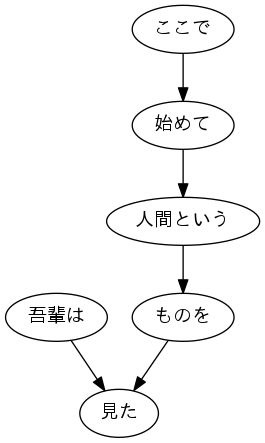

In [6]:
import subprocess
import pydot
from IPython.display import Image, display
                        
def knock_44():
    INPUT_FILE_PATH = '../data/knock_44_input.txt'
    OUTPUT_FILE_PATH = '../data/knock_44_output.txt'

    def gen_chunks_in_file():
        with open(OUTPUT_FILE_PATH) as f:
            chunks_in_a_sentence = []
            for is_eos, sentence in groupby(f, key=lambda line: line.rstrip('\n') == 'EOS'):
                if is_eos:
                    for chunk in chunks_in_a_sentence:
                        # 各chunkの係り先のchunkに対して、自身のidをsrcとして設定
                        dst = chunk.dst
                        if dst is not None:
                            chunks_in_a_sentence[dst].add_src(chunk.chunk_id)
                    yield chunks_in_a_sentence
                    chunks_in_a_sentence = []
                else:
                    dependency_info = None
                    for is_start_of_chunk, chunk_info in groupby(sentence, key=lambda line: 0 < len(line) and line[0] == '*'):
                        if is_start_of_chunk:
                            dependency_info = list(chunk_info)[0]
                        else:
                            morphs_info = list(chunk_info)
                            chunk = Chunk(dependency_info, morphs_info)
                            chunks_in_a_sentence.append(chunk)
    
    def write_dependency_to_file(text):
        CMD_CAT = 'cat %s' % INPUT_FILE_PATH
        CMD_CABOCHA = 'cabocha -f1 -o %s' % OUTPUT_FILE_PATH
        
        with open(INPUT_FILE_PATH, "w") as f:
            f.write(text)
        ps = subprocess.Popen(CMD_CAT.split(' '), stdout=subprocess.PIPE)
        subprocess.check_call(CMD_CABOCHA.split(' '), stdin=ps.stdout)
        ps.wait()
        
    def to_pydot_node(chunk):
        surface = chunk.get_surface_except_punctuation()
        if surface == '':
            # 記号の除去後に空文字の場合はノードとして追加しない
            return None
        return pydot.Node(chunk.chunk_id, label=surface)
    
    def to_pydot_edge(src_chunk, dst_chunk):
        src_surface = src_chunk.get_surface_except_punctuation()
        dst_surface = dst_chunk.get_surface_except_punctuation()
        if src_surface == '' or dst_surface == '':
            # 記号の除去後に空文字の場合はノードとして追加しない
            return None
        return graph.add_edge(pydot.Edge(src_chunk.chunk_id, dst_chunk.chunk_id))
    
    text = input()
    write_dependency_to_file(text)
    graph = pydot.Dot(graph_type='digraph')
    for chunks in gen_chunks_in_file():
        for chunk in chunks:
            print(chunk)
            
            node = to_pydot_node(chunk)
            if not node:
                continue
            graph.add_node(node)
                
            dst = chunk.dst
            if not dst:
                continue
            edge = to_pydot_edge(chunk, chunks[dst])
            if not edge:
                continue
            graph.add_edge(edge)
            
    plt = Image(graph.create_png())
    display(plt)

knock_44()

## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

    始める  で
    見る    は を
このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [7]:
def knock_45():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                srcs_particles = []
                for src in chunk.srcs:
                    src_particle = chunks_in_a_sentence[src].get_last_particle()
                    if src_particle:
                        srcs_particles.append(src_particle)
                if len(srcs_particles) == 0:
                    continue
                yield '%s\t%s' % (chunk.get_first_verb(), ' '.join(sorted(srcs_particles)))

with open('../data/knock_45.txt', mode='w') as f:
    for i, s in enumerate(knock_45()):
        if i < 20:
            print(s)
        f.write(s + '\n')

生れる	で
つく	か が
泣く	で
する	て は
始める	で
見る	は を
聞く	で
捕える	を
煮る	て
食う	て
思う	から
載せる	に
持ち上げる	て と
ある	が
落ちつく	で
見る	て を
見る	の
思う	と
残る	が でも
する	をもって


In [8]:
# コーパス中で頻出する述語と格パターンの組み合わせ
!cat ../data/knock_45.txt | LC_ALL=C sort | uniq -c | sort -nr 2>/dev/null | head -20

    704 云う	と
    452 する	を
    333 思う	と
    202 ある	が
    199 なる	に
    188 する	に
    175 見る	て
    159 する	と
    117 する	が
    113 する	に を
     98 見る	を
     97 見える	と
     90 する	て を
     85 する	は
     61 する	て
     60 する	が を
     60 する	も
     60 もつ	を
     57 ある	の
     56 云う	を


In [9]:
#「する」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../data/knock_45.txt | grep '^する' | LC_ALL=C sort | uniq -c | sort -nr 2>/dev/null | head -20 

    452 する	を
    188 する	に
    159 する	と
    117 する	が
    113 する	に を
     90 する	て を
     85 する	は
     61 する	て
     60 する	が を
     60 する	も
     51 する	から
     51 する	と を
     46 する	で を
     40 する	の
     39 する	と は
     37 する	から を
     37 する	は を
     36 する	で
     32 する	が と
     32 する	が に


In [10]:
#「見る」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../data/knock_45.txt | grep '^見る' | LC_ALL=C sort | uniq -c | sort -nr 2>/dev/null | head -20 

    175 見る	て
     98 見る	を
     23 見る	て て
     21 見る	て も
     20 見る	から
     17 見る	と
     13 見る	て は
     12 見る	から て
     12 見る	で
      9 見る	に
      8 見る	て て は
      8 見る	て と
      8 見る	が
      7 見る	が を
      7 見る	と へ
      7 見る	に を
      6 見る	て は を
      6 見る	は は
      6 見る	も
      5 見る	から て に


In [11]:
#「与える」の格パターン（コーパス中で出現頻度の高い順に並べよ）
!cat ../data/knock_45.txt | grep '^与える' | LC_ALL=C sort | uniq -c | sort -nr

      4 与える	に を
      3 与える	て に を
      2 与える	て に は を
      2 与える	ば を
      1 与える	けれども は を
      1 与える	か として
      1 与える	が て と に は は を
      1 与える	て に に は を
      1 与える	て と は を
      1 与える	は は も
      1 与える	が を


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

    始める  で      ここで
    見る    は を   吾輩は ものを

In [12]:
from itertools import islice

def knock_46():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                srcs_particles = []
                srcs_arguments = []
                for src in chunk.srcs:
                    src_chunk = chunks_in_a_sentence[src]
                    src_particle = src_chunk.get_last_particle()
                    if src_particle:
                        srcs_particles.append(src_particle)
                        srcs_arguments.append(src_chunk.get_surface_except_punctuation())
                if len(srcs_particles) == 0:
                    continue
                    
                # 助詞の辞書順になるように、助詞と項をソート
                particles_and_arguments = zip(srcs_particles, srcs_arguments)
                ordered_particles, ordered_arguments = zip(*sorted(particles_and_arguments, key=lambda x: x[0]))
                yield '%s\t%s\t%s' % (chunk.get_first_verb(), ' '.join(ordered_particles), ' '.join(ordered_arguments))
    
for s in islice(knock_46(), 20):
    print(s)

生れる	で	どこで
つく	か が	生れたか 見当が
泣く	で	所で
する	て は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て
思う	から	なかったから
載せる	に	掌に
持ち上げる	て と	載せられて スーと
ある	が	感じが
落ちつく	で	上で
見る	て を	落ちついて 顔を
見る	の	ものの
思う	と	ものだと
残る	が でも	感じが 今でも
する	をもって	第一毛をもって


## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．

    返事をする      と に は        及ばんさと 手紙に 主人は

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語（サ変接続名詞+を+動詞）
- コーパス中で頻出する述語と助詞パターン

In [13]:
from itertools import islice

def knock_47():
    for chunks_in_a_sentence in gen_chunks_in_sentence():
        for chunk in chunks_in_a_sentence:
            if chunk.has_verb():
                sahen_noun_and_verb = None
                srcs_particles = []
                srcs_arguments = []
                for src in chunk.srcs:
                    src_chunk = chunks_in_a_sentence[src]
                    src_particle = src_chunk.get_last_particle()
                    if src_particle:
                        if src_particle == 'を':
                            sahen_noun_wo = src_chunk.get_sahen_noun_and_wo()
                            if sahen_noun_wo:
                                # サ変接続名詞 + を（助詞） + 動詞の基本形
                                sahen_noun_and_verb = sahen_noun_wo + chunk.get_first_verb()
                        else:
                            srcs_particles.append(src_particle)
                            srcs_arguments.append(src_chunk.get_surface_except_punctuation())
                if not sahen_noun_and_verb:
                    continue
                    
                ordered_particles = []
                ordered_arguments = []
                if len(srcs_particles) != 0:
                    # 助詞の辞書順になるように、助詞と項をソート
                    particles_and_arguments = zip(srcs_particles, srcs_arguments)
                    ordered_particles, ordered_arguments = zip(*sorted(particles_and_arguments, key=lambda x: x[0]))
                yield '%s\t%s\t%s' % (sahen_noun_and_verb, ' '.join(ordered_particles), ' '.join(ordered_arguments))
    
with open('../data/knock_47.txt', mode='w') as f:
    for i, s in enumerate(knock_47()):
        if i < 20:
            print(s)
        f.write(s + '\n')

決心をする	と	こうと
返報をする	んで	偸んで
昼寝をする		
昼寝をする	が	彼が
迫害を加える	て	追い廻して
生活をする	が	我等猫族が
話をする		
投書をする	て へ	やって ほととぎすへ
話をする	に	時に
写生をする		
昼寝をする	て	出て
彩色を見る		
欠伸をする	から て て	なったから して 押し出して
報道をする	に	耳に
挨拶をする		
御馳走を食う	と	見ると
問答をする		
雑談をする	ながら は	寝転びながら 黒は
自慢をする		
呼吸を飲み込む	から	なってから
